In [34]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [43]:
 #=== Standard library ===
import os
import warnings

# === Imbalanced learning ===
from imblearn.over_sampling import BorderlineSMOTE

# === Statistics ===
from scipy.stats import uniform, randint

# === Deep Learning (PyTorch) ===
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc

# === Explainability ===
import shap

# === Notebook utilities ===
from IPython.display import FileLink, display, HTML

# === Joblib ===
import joblib

# === Settings ===
warnings.filterwarnings("ignore")
np.random.seed(123)
torch.manual_seed(123)

RANDOM_STATE = 42
TARGET_COL = "label"
DROP_COLS  = ["patient_id", "date"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EXPERIMENT_NAME = "binary_classification_blood_pressure_perceptron"

torch.__version__, device
class DEMENTIAANNClassifier(nn.Module):
    def __init__(self, input_dim, neurons, dropout=0.10):
        super(DEMENTIAANNClassifier, self).__init__()

        self.layer1 = nn.Linear(input_dim, neurons[0])
        self.layer2 = nn.Linear(neurons[0], neurons[1])
        self.layer3 = nn.Linear(neurons[1], neurons[2])
        self.layer4 = nn.Linear(neurons[2], neurons[3])
        self.output_layer = nn.Linear(neurons[3], 1)

        self.bn1 = nn.BatchNorm1d(neurons[0])
        self.bn2 = nn.BatchNorm1d(neurons[1])
        self.bn3 = nn.BatchNorm1d(neurons[2])
        self.bn4 = nn.BatchNorm1d(neurons[3])

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.gelu(self.bn1(self.layer1(x)))
        x = self.dropout(x)

        x = self.gelu(self.bn2(self.layer2(x)))
        x = self.dropout(x)

        x = self.gelu(self.bn3(self.layer3(x)))
        x = self.dropout(x)

        x = self.gelu(self.bn4(self.layer4(x)))
        x = self.output_layer(x)

        return x.squeeze(1)  # shape (batch,)

    def fit(self, train_loader, val_loader, epochs=200, lr=1e-3, weight_decay=1e-4, device='cpu', patience=20):
        self.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

        best_val_loss = float('inf')
        patience_counter = 0

        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [], 'val_auc': []
        }

        for epoch in range(epochs):
            # ========= TRAIN =========
            self.train()
            running_loss = 0.0
            correct, total = 0, 0

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)

                outputs = outputs.view(-1).float()
                targets = targets.view(-1).float()

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                preds = (torch.sigmoid(outputs) > 0.5).long()
                correct += (preds == targets.long()).sum().item()
                total += targets.size(0)
                running_loss += loss.item() * inputs.size(0)

            train_loss = running_loss / len(train_loader.dataset)
            train_acc = correct / total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)


            # ========= VALIDATION =========
            self.eval()
            val_loss = 0.0
            correct_val, total_val = 0, 0
            all_probas, all_true = [], []

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = self(inputs)
                    outputs = outputs.view(-1).float()
                    targets = targets.view(-1).float()

                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

                    proba = torch.sigmoid(outputs)
                    pred = (proba > 0.5).long()

                    correct_val += (pred == targets.long()).sum().item()
                    total_val += targets.size(0)

                    all_probas.append(proba.cpu())
                    all_true.append(targets.cpu())

            val_loss /= len(val_loader.dataset)
            val_acc = correct_val / total_val

            y_true = torch.cat(all_true).numpy()
            y_proba = torch.cat(all_probas).numpy()

            try:
                val_auc = roc_auc_score(y_true, y_proba)
            except ValueError:
                val_auc = float('nan')

            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_auc'].append(val_auc)

            # log
            print(
                f"Epoch [{epoch+1}/{epochs}] | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}"
            )

            # Early stopping based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_state = self.state_dict()  # save best model
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

            scheduler.step(val_loss)

        # restore best model
        self.load_state_dict(best_state)

        return history



    def test(self, test_loader, device='cpu'):
        self.to(device)
        self.eval()

        all_preds, all_probas, all_targets = [], [], []
        correct, total = 0, 0
        test_loss = 0.0
        criterion = nn.BCEWithLogitsLoss()
        history = {'test_loss': [], 'test_acc': [], 'test_auc': []}

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = self(inputs)

                outputs = outputs.view(-1).float()
                targets = targets.view(-1).float()

                loss = criterion(outputs, targets)

                proba = torch.sigmoid(outputs)
                pred = (proba > 0.5).long()

                all_preds.append(pred.cpu())
                all_probas.append(proba.cpu())
                all_targets.append(targets.cpu())

                correct += (pred == targets.long()).sum().item()
                total += targets.size(0)
                test_loss += loss.item() * inputs.size(0)

        test_acc = correct / total
        test_loss /= len(test_loader.dataset)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        y_true = torch.cat(all_targets).numpy().astype(int)
        y_pred = torch.cat(all_preds).numpy().astype(int)
        y_proba = torch.cat(all_probas).numpy().astype(float)

        try:
            auc = roc_auc_score(y_true, y_proba)
        except ValueError:
            auc = float('nan')

        report = classification_report(y_true, y_pred, output_dict=False)
        history['test_auc'].append(auc)

        print(
            f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test AUC: {auc:.4f}"
            )

        return test_acc, auc, report, history

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from scipy import stats
import statsmodels.api as sm

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score, recall_score, precision_score, f1_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import pickle

In [58]:
N_BAYES_PATH = "/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/MODELOS/gaussian_nb_smote_combined.pkl"
LOG_REG_PATH   = "/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/best_RL_model.pkl"
SVM_PATH  = "/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/MODELOS/SVM_model.pkl"
XGBOOST_PATH = "/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/MODELOS/XGBoost_model.pkl"
CATBOOST_PATH  = "/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/MODELOS/final_catboost_model.pkl"
NNN_PATH = "/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/nnn_model.pkl"

In [44]:
TEST_PATH  = "/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/test_data (1).csv"

In [46]:
test  = pd.read_csv(TEST_PATH)
X_test  = test.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in test.columns])
y_test  = test[TARGET_COL].copy()

In [28]:
def load_model(path):
  with open(path, 'rb') as to_read:
      model = pickle.load(to_read)
  return model

In [30]:
Nbayes = load_model(N_BAYES_PATH)

In [59]:
LogR= load_model(LOG_REG_PATH)

In [32]:
SVM =load_model(SVM_PATH)

In [36]:
CatBoost = load_model(CATBOOST_PATH)

In [47]:
NN = load_model(NNN_PATH)

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_on_test_set(model, X_test, y_test):
  """
  Evaluates a given model on the test set, adapting to different model types.

  Args:
    model: The trained model (can be DEMENTIAANNClassifier or a scikit-learn compatible model).
    X_test (pd.DataFrame): Features of the test set.
    y_test (pd.Series): True labels of the test set.

  Returns:
    tuple: A tuple containing (accuracy, precision, recall, f1_score, roc_auc).
  """

  if isinstance(model, DEMENTIAANNClassifier):
    # For DEMENTIAANNClassifier (PyTorch model)
    model.to(device)
    model.eval()

    # Prepare data for DataLoader
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    all_preds, all_probas, all_targets = [], [], []

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        outputs = outputs.view(-1).float()

        proba = torch.sigmoid(outputs)
        pred = (proba > 0.5).long()

        all_preds.append(pred.cpu())
        all_probas.append(proba.cpu())
        all_targets.append(targets.cpu())

    y_true_ann = torch.cat(all_targets).numpy().astype(int)
    y_pred_ann = torch.cat(all_preds).numpy().astype(int)
    y_proba_ann = torch.cat(all_probas).numpy().astype(float)

    accuracy = accuracy_score(y_true_ann, y_pred_ann)
    precision = precision_score(y_true_ann, y_pred_ann, zero_division=0)
    recall = recall_score(y_true_ann, y_pred_ann, zero_division=0)
    f1 = f1_score(y_true_ann, y_pred_ann, zero_division=0)
    roc_auc = roc_auc_score(y_true_ann, y_proba_ann)

  else:
    # For scikit-learn compatible models
    y_pred = model.predict(X_test)

    # Determine prediction probabilities for ROC AUC
    y_proba = None
    if hasattr(model, 'predict_proba'):
      y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
      y_proba = model.decision_function(X_test)
    else:
      warnings.warn("Model does not have 'predict_proba' or 'decision_function'. ROC AUC will be calculated using binary predictions.")
      y_proba = y_pred # Fallback, will likely yield poor AUC for binary predictions

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    try:
      roc_auc = roc_auc_score(y_test, y_proba)
    except ValueError:
      # This can happen if y_proba contains only one class
      roc_auc = float('nan')

  return accuracy, precision, recall, f1, roc_auc

print("Function `evaluate_model_on_test_set` defined successfully.")

Function `evaluate_model_on_test_set` defined successfully.


In [60]:
model_evaluations = []

# Evaluate Naive Bayes
accuracy, precision, recall, f1, roc_auc = evaluate_model_on_test_set(Nbayes, X_test, y_test)
model_evaluations.append({
    'Model': 'Naive Bayes',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Roc_auc': roc_auc
})

# Evaluate Logistic Regression
accuracy, precision, recall, f1, roc_auc = evaluate_model_on_test_set(LogR, X_test, y_test)
model_evaluations.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Roc_auc': roc_auc
})

# Evaluate SVM
accuracy, precision, recall, f1, roc_auc = evaluate_model_on_test_set(SVM, X_test, y_test)
model_evaluations.append({
    'Model': 'SVM',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Roc_auc': roc_auc
})

# Evaluate CatBoost
accuracy, precision, recall, f1, roc_auc = evaluate_model_on_test_set(CatBoost, X_test, y_test)
model_evaluations.append({
    'Model': 'CatBoost',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Roc_auc': roc_auc
})

# Evaluate Custom Neural Network
accuracy, precision, recall, f1, roc_auc = evaluate_model_on_test_set(NN, X_test, y_test)
model_evaluations.append({
    'Model': 'Neural Network',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Roc_auc': roc_auc
})

# Create DataFrame from evaluations
results_df = pd.DataFrame(model_evaluations)
print(results_df)

                 Model  Accuracy  Precision    Recall        F1   Roc_auc
0          Naive Bayes  0.516484   0.200000  0.714286  0.312500  0.616215
1  Logistic Regression  0.624176   0.186335  0.428571  0.259740  0.606308
2                  SVM  0.729670   0.232323  0.328571  0.272189  0.613525
3             CatBoost  0.846154   0.500000  0.200000  0.285714  0.686382
4       Neural Network  0.742857   0.186667  0.200000  0.193103  0.562486


                 Model  Accuracy  Precision    Recall        F1   Roc_auc
0          Naive Bayes  0.516484   0.200000  0.714286  0.312500  0.616215
1  Logistic Regression  0.624176   0.186335  0.428571  0.259740  0.606308
2                  SVM  0.729670   0.232323  0.328571  0.272189  0.613525
3             CatBoost  0.846154   0.500000  0.200000  0.285714  0.686382
4       Neural Network  0.742857   0.186667  0.200000  0.193103  0.562486
5              XGBoost  0.646154   0.194631  0.414286  0.264840  0.625343


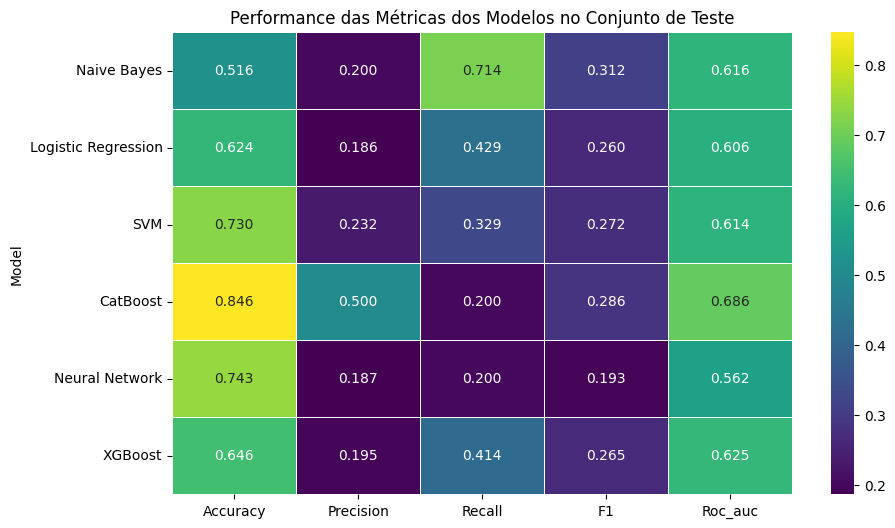

In [61]:
XGBoost = load_model(XGBOOST_PATH)

# Evaluate XGBoost
accuracy, precision, recall, f1, roc_auc = evaluate_model_on_test_set(XGBoost, X_test, y_test)
model_evaluations.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Roc_auc': roc_auc
})

# Create DataFrame from all evaluations
results_df = pd.DataFrame(model_evaluations)

# Display the results DataFrame as a table
print(results_df)

# Prepare data for heatmap (retaining this for previous context if needed elsewhere, but user requested table)
results_heatmap = results_df.set_index('Model')

plt.figure(figsize=(10, 6))
sns.heatmap(results_heatmap, annot=True, fmt=".3f", cmap="viridis", linewidths=.5)
plt.title('Performance das Métricas dos Modelos no Conjunto de Teste')
plt.show()

**AVALIANDO MÉTRICAS NA CLASSE AUSENCIA DE EVENTOS ADVERSOS**

In [62]:
def get_class_0_metrics(model, X_test, y_test):
  """
  Extracts precision and recall for class '0' from a given model's predictions on the test set,
  handling both scikit-learn models and the custom PyTorch neural network.

  Args:
    model: The trained model (can be DEMENTIAANNClassifier or a scikit-learn compatible model).
    X_test (pd.DataFrame): Features of the test set.
    y_test (pd.Series): True labels of the test set.

  Returns:
    tuple: A tuple containing (precision for class 0, recall for class 0).
  """

  if isinstance(model, DEMENTIAANNClassifier):
    # For DEMENTIAANNClassifier (PyTorch model)
    model.to(device)
    model.eval()

    # Prepare data for DataLoader
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    all_preds, all_targets = [], []

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        outputs = outputs.view(-1).float()

        proba = torch.sigmoid(outputs)
        pred = (proba > 0.5).long()

        all_preds.append(pred.cpu())
        all_targets.append(targets.cpu())

    y_true_ann = torch.cat(all_targets).numpy().astype(int)
    y_pred_ann = torch.cat(all_preds).numpy().astype(int)

    y_true = y_true_ann
    y_pred = y_pred_ann

  else:
    # For scikit-learn compatible models
    y_pred = model.predict(X_test)
    y_true = y_test

  # Generate classification report
  report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

  # Extract precision and recall for class '0'
  precision_0 = report_dict['0']['precision']
  recall_0 = report_dict['0']['recall']

  return precision_0, recall_0

print("Function `get_class_0_metrics` defined successfully.")

Function `get_class_0_metrics` defined successfully.


In [63]:
metrics_class_0 = []

# Models to evaluate
models_to_evaluate = {
    'Naive Bayes': Nbayes,
    'Logistic Regression': LogR,
    'SVM': SVM,
    'CatBoost': CatBoost,
    'XGBoost': XGBoost,
    'Neural Network': NN
}

for model_name, model_obj in models_to_evaluate.items():
    precision_0, recall_0 = get_class_0_metrics(model_obj, X_test, y_test)
    metrics_class_0.append({
        'Model': model_name,
        'Precision (Class 0)': precision_0,
        'Recall (Class 0)': recall_0
    })

metrics_df_class_0 = pd.DataFrame(metrics_class_0)
print(metrics_df_class_0)

                 Model  Precision (Class 0)  Recall (Class 0)
0          Naive Bayes             0.902439          0.480519
1  Logistic Regression             0.863946          0.659740
2                  SVM             0.867978          0.802597
3             CatBoost             0.868852          0.963636
4              XGBoost             0.866013          0.688312
5       Neural Network             0.852632          0.841558


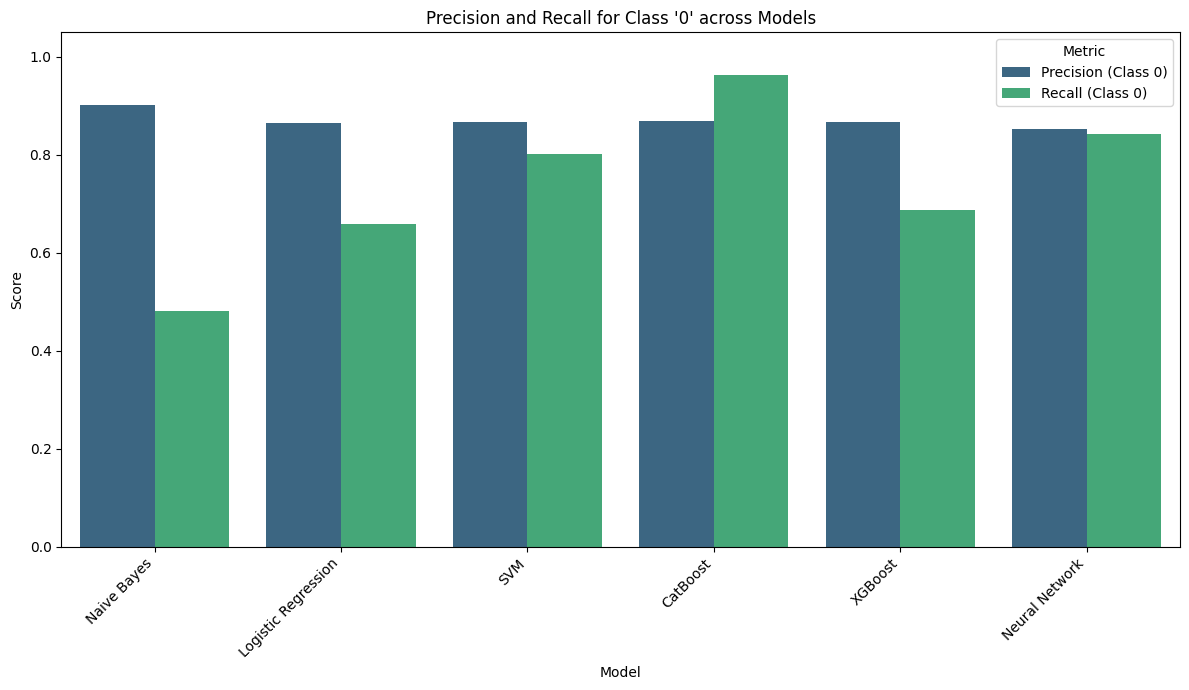

In [64]:
metrics_melted = metrics_df_class_0.melt(id_vars='Modelo', var_name='Metrica', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Precisão e Recall para a Class \'0\' entre Modelso')
plt.ylabel('Score')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05) # Metrics are between 0 and 1
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## Avaliando Métricas para a Classe '1' (Presença de Eventos Adversos)

In [65]:
from sklearn.metrics import classification_report

def get_class_1_metrics(model, X_test, y_test):
  """
  Extracts precision and recall for class '1' from a given model's predictions on the test set,
  handling both scikit-learn models and the custom PyTorch neural network.

  Args:
    model: The trained model (can be DEMENTIAANNClassifier or a scikit-learn compatible model).
    X_test (pd.DataFrame): Features of the test set.
    y_test (pd.Series): True labels of the test set.

  Returns:
    tuple: A tuple containing (precision for class 1, recall for class 1).
  """

  if isinstance(model, DEMENTIAANNClassifier):
    model.to(device)
    model.eval()

    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    all_preds, all_targets = [], []

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        outputs = outputs.view(-1).float()

        proba = torch.sigmoid(outputs)
        pred = (proba > 0.5).long()

        all_preds.append(pred.cpu())
        all_targets.append(targets.cpu())

    y_true = torch.cat(all_targets).numpy().astype(int)
    y_pred = torch.cat(all_preds).numpy().astype(int)

  else:
    y_pred = model.predict(X_test)
    y_true = y_test

  report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

  precision_1 = report_dict['1']['precision']
  recall_1 = report_dict['1']['recall']

  return precision_1, recall_1

print("Function `get_class_1_metrics` defined successfully.")

Function `get_class_1_metrics` defined successfully.


In [66]:
metrics_class_1 = []

# Models to evaluate (reusing the dictionary from previous step)
models_to_evaluate = {
    'Naive Bayes': Nbayes,
    'Logistic Regression': LogR,
    'SVM': SVM,
    'CatBoost': CatBoost,
    'XGBoost': XGBoost,
    'Neural Network': NN
}

for model_name, model_obj in models_to_evaluate.items():
    precision_1, recall_1 = get_class_1_metrics(model_obj, X_test, y_test)
    metrics_class_1.append({
        'Model': model_name,
        'Precision (Class 1)': precision_1,
        'Recall (Class 1)': recall_1
    })

metrics_df_class_1 = pd.DataFrame(metrics_class_1)
print(metrics_df_class_1)

                 Model  Precision (Class 1)  Recall (Class 1)
0          Naive Bayes             0.200000          0.714286
1  Logistic Regression             0.186335          0.428571
2                  SVM             0.232323          0.328571
3             CatBoost             0.500000          0.200000
4              XGBoost             0.194631          0.414286
5       Neural Network             0.186667          0.200000


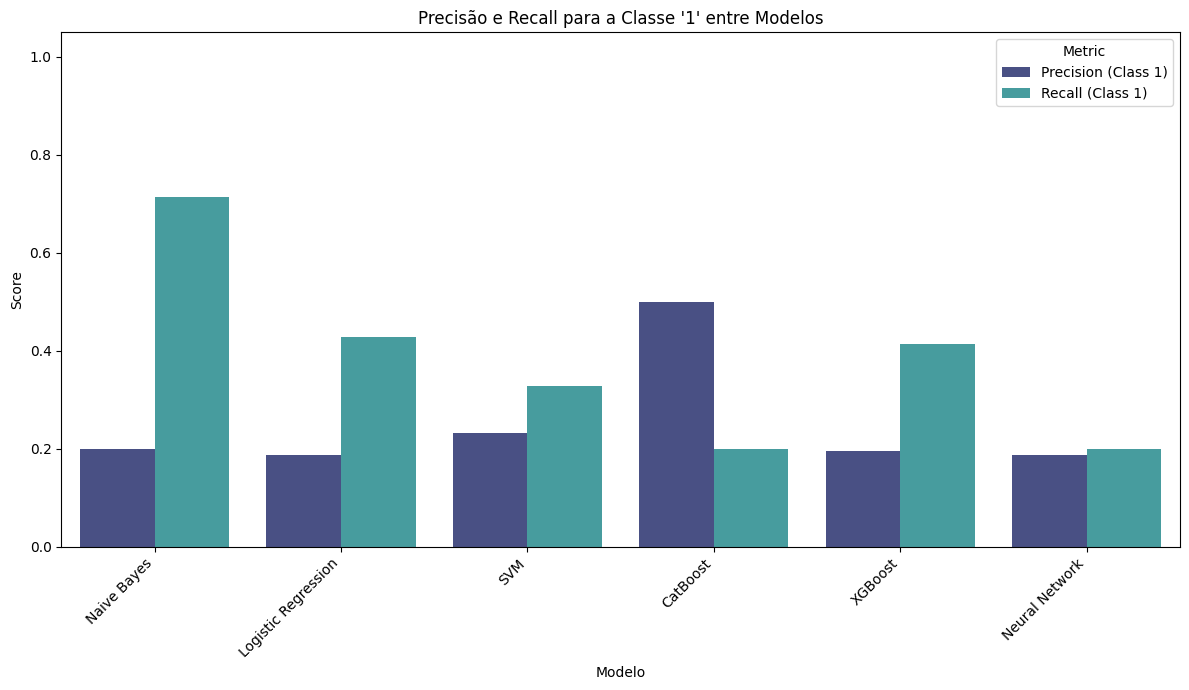

In [67]:
metrics_melted_1 = metrics_df_class_1.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted_1, palette='mako')
plt.title('Precisão e Recall para a Classe \'1\' entre Modelos')
plt.ylabel('Score')
plt.xlabel('Modelo')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05) # Metrics are between 0 and 1
plt.legend(title='Metric')
plt.tight_layout()
plt.show()